<div style="border: 1px solid black">
<b><center><font size="4">Mini Projecto 01</font></center></b>

</div>

**Notebook base on**: [Ricardo Campos](https://www.di.ubi.pt/~rcampos)<br>
**Notebook Developed by**: Rene Jerez<br>
**Notebook Co-Author**: ChatGPT and OpenAI API Image-View<br>
**email:**  rene.jerez@ubi.pt<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span>
<a href="#Tarefa 1" data-toc-modified-id="Tarefa 1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tarefa 1</a></span><ul class="toc-item"><li><span>
<a href="#100 ficheiros" data-toc-modified-id="100 ficheiros-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>100 ficheiros</a></span></li><li><span>
<a href="#Guardar json" data-toc-modified-id="Guardar json-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Guardar json</a></span></li><li><span>
<a href="#Carregar json" data-toc-modified-id="Carregar json-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Carregar json</a></span></li><li><span>
<a href="#Imprimir 5 json" data-toc-modified-id="Imprimir 5 json-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Imprimir 5 json</a></span></li><li><span>
<a href="#Nuvem de Palavras" data-toc-modified-id="Nuvem de Palavras-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Nuvem de Palavras</a></span></li></ul></li>
<li><span>
<a href="#Tarefa 2" data-toc-modified-id="Tarefa 2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tarefa 2</a></span><ul class="toc-item"><li><span>
<a href="#Wikipedia imagens" data-toc-modified-id="Wikipedia imagens-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Wikipedia imagens</a></span></li></ul></li>
<li><span>
<a href="#Tarefa 3" data-toc-modified-id="Tarefa 3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tarefa 3</a></span><ul class="toc-item"><li><span>
<a href="#API Search" data-toc-modified-id="API Search-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>API Search</a></span></li><li><span>
<a href="#Guardar dinamicamente" data-toc-modified-id="Guardar dinamicamente-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Guardar dinamicamente</a></span></li><li><span>
<a href="#Imprimir 5 json" data-toc-modified-id="Imprimir 5 json-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Imprimir 5 json</a></span></li><li><span>
<a href="#Prêmio Arquivo PT" data-toc-modified-id="Prêmio Arquivo PT-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Prêmio Arquivo PT</a></span></li></ul></li>



</div>

# Tarefa 1

 Familiarização com a obtenção de dados a partir de ficheiros pdf

1. Reúna um conjunto aproximado de 100 ficheiros em formato pdf relacionados com
uma temática à sua escolha (e.g., artigos científicos; documentos do parlamento
europeu; patentes; programas eleitorais; etc). Proceda à extração do texto de cada
ficheiro com recurso a bibliotecas Python.

In [56]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import pprint
from openai import OpenAI
import time

In [6]:
# The URL of the page containing the links
page_url = 'https://www.ubi.pt/Pessoas'

# Fetch the content of the page
response = requests.get(page_url)
page_content = response.content

# Parse the page content using BeautifulSoup
soup = BeautifulSoup(page_content, 'html.parser')

# Find all links in the page (assuming they are contained in <a> tags)
links = soup.find_all('a')

# Create a list to hold your links and texts
link_table = []

# Loop through all found <a> tags
for link in links:
    href = link.get('href')  # Extract the href attribute (the URL)

    # Skip fragment identifiers and ensure the URL is complete
    if href and not href.startswith('#'):
        # Optional: Concatenate with the base URL if href is a relative URL
        if not href.startswith('http'):
            href = requests.compat.urljoin(page_url, href)

        # Store the link and an empty string for the text in the table
        link_table.append([href, ""])

# Convert the list to a DataFrame for easier handling
df = pd.DataFrame(link_table, columns=['Link', 'Text'])

# Filter for links containing 'Pessoa'
df = df[df['Link'].str.contains('Pessoa', na=False)]

# Remove duplicate links
df.drop_duplicates(subset='Link', inplace=True)


# Initialize columns name and image
df['ColunaNome'] = "Not found"
df['Photo'] = "Not found"

# Now iterate over the DataFrame, access each link, and fetch the text, Name and image url
for index, row in df.iterrows():
    link_url = row['Link']

    try:
        # Fetch the content of the linked page
        linked_page_response = requests.get(link_url)
        linked_page_content = linked_page_response.content

        # Parse the linked page
        linked_soup = BeautifulSoup(linked_page_content, 'html.parser')

        # Extract just content from a person without garbage
        specific_div = linked_soup.find('div', id="ConteudoHolder_LV_Detalhe_Pessoa_Panel_Visibilidade_0")
        # Extract text from the specific div, if it exists
        if specific_div:
            text = specific_div.get_text(separator=' ', strip=True)
        else:
            text = "Specific div not found."
        # Update the 'Text' column in the DataFrame with the extracted text
        df.at[index, 'Text'] = text

        # Extract the person name
        coluna_nome_elements = linked_soup.find_all(class_="colunaNome")
        # Extract text from these elements, if they exist
        if coluna_nome_elements:
            coluna_nome_texts = [elem.get_text(separator=' ', strip=True) for elem in coluna_nome_elements]
            # Join all found texts into a single string (or handle as you see fit)
            coluna_nome_text = ' | '.join(coluna_nome_texts)
        else:
            coluna_nome_text = "colunaNome elements not found."
        # Update the 'ColunaNome' column in the DataFrame with the extracted text
        df.at[index, 'ColunaNome'] = coluna_nome_text

        # Find the first element with class 'blkFicheiro ficheiroImagem' and extract the 'src' of the img tag
        photo_element = linked_soup.find(class_="blkFicheiro ficheiroImagem")
        if photo_element and photo_element.find('img'):
            photo_src = photo_element.find('img')['src']
            # Optional: Concatenate with the base URL if 'src' is a relative URL
            if not photo_src.startswith('http'):
                photo_src = requests.compat.urljoin(link_url, photo_src)
        else:
            photo_src = "Photo not found."
        # Update the 'Photo' column in the DataFrame with the photo URL
        df.at[index, 'Photo'] = photo_src

    except requests.exceptions.RequestException as e:
        # Handle exceptions like missing schema, connection errors, etc.
        print(f"Error fetching {link_url}: {e}")
        df.at[index, 'Text'] = "Error fetching content."
        df.at[index, 'ColunaNome'] = "Error fetching content."
        df.at[index, 'Photo'] = "Error fetching content."

    # Be mindful of the website's policy on automated requests and add a delay if necessary


In [7]:
#remove the first link because is a root of Pessoas page
df = df.iloc[1:]

In [8]:
# From text extract info such as Cargo, Unidades Curriculares, Artigos and Nota Biografica
def split_text(text):
    # Split the text based on the specified headings
    parts = re.split(r"(Sector  — Cargos/Funções|Unidades Curriculares|Contactos|Artigo em conferência/Conference paper|Nota Biográfica)", text)

    # Initialize a dictionary to hold the split parts
    split_parts = {'Sector_Cargos': '', 'Unidades_Curriculares': '','Contactos': '', 'Artigo_Conferencia': '', 'Nota_Biografica': ''}

    for i in range(1, len(parts), 2):
        if parts[i].startswith('Sector  — Cargos/Funções'):
            split_parts['Sector_Cargos'] = parts[i + 1]
        elif parts[i].startswith('Unidades Curriculares'):
            split_parts['Unidades_Curriculares'] = parts[i + 1]
        elif parts[i].startswith('Contactos'):
            split_parts['Contactos'] = parts[i + 1]    
        elif parts[i].startswith('Artigo em conferência/Conference paper'):
            split_parts['Artigo_Conferencia'] = parts[i + 1]
        elif parts[i].startswith('Nota Biográfica'):
            split_parts['Nota_Biografica'] = parts[i + 1]

    return pd.Series(split_parts)

# Apply the function to the 'Text' column and split the results into separate columns
split_columns = df['Text'].apply(split_text)
df = pd.concat([df, split_columns], axis=1)

# Now 'df' has four new columns: 'Sector_Cargos', 'Unidades_Curriculares', 'Artigo_Conferencia', and 'Nota_Biografica'


In [95]:
df.head(5)

Link  \
225      https://www.ubi.pt/Pessoa/abel.abejas   
227         https://www.ubi.pt/Pessoa/ajpgomes   
229           https://www.ubi.pt/Pessoa/abilio   
231  https://www.ubi.pt/Pessoa/adelaide.santos   
233             https://www.ubi.pt/Pessoa/amaa   

                                                  Text  \
225  Sector  — Cargos/Funções Departamento de Ciênc...   
227  Sector  — Cargos/Funções Departamento de Infor...   
229  Sector  — Cargos/Funções Departamento de Engen...   
231  Sector  — Cargos/Funções Contabilidade e Tesou...   
233  Sector  — Cargos/Funções Divisão de Aprovision...   

                                            ColunaNome  \
225          Abel Garcia Abejas Assistente Convidado/a   
227   Abel João Padrão Gomes Professor/a Catedrático/a   
229  Abílio Manuel Pereira da Silva Professor/a Ass...   
231           Adelaide João Fonseca Vale Mendes Santos   
233   Adélia Maria Assis de Abrunhosa Chefe de Divisão   

                                                 Photo  \
225  https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg   
227   https://www.ubi.pt/Ficheiros/Pessoas/902/902.jpg   
229   https://www.ubi.pt/Ficheiros/Pessoas/689/689.jpg   
231                                   Photo not found.   
233   https://www.ubi.pt/Ficheiros/Pessoas/814/814.jpg   

                                         Sector_Cargos  \
225   Departamento de Ciências Médicas — Docente do...   
227   Departamento de Informática — Docente do Depa...   
229   Departamento de Engenharia Eletromecânica — D...   
231   Contabilidade e Tesouraria — Funcionário/a no...   
233   Divisão de Aprovisionamento e Património — Ch...   

                                 Unidades_Curriculares  \
225                    A Arte da Medicina (15099)2023    
227   Tecnologias de Jogos de Vídeo (13828)2023 Com...   
229   Materiais de Construção Aeroespacial (10368)2...   
231                                                      
233                                                      

                                             Contactos  \
225                                 abel÷abejasðubi÷pt   
227     ajpgomesðubi÷pt 275242086 1606 CienciaVitae.pt   
229   abilioðubi÷pt 275242050 275329926 3926 3929 C...   
231                        adelaide÷santosðubi÷pt 2806   
233                         amaaðubi÷pt 275329155 2046   

                                    Artigo_Conferencia  \
225                                                      
227                                                      
229   Macedo, Duarte F.; Filipe J. Oliveira; Marian...   
231                                                      
233                                                      

                                       Nota_Biografica  \
225                                                      
227                                                      
229   (Informação importada da plataforma CiênciaVi...   
231                                                      
233                                                      

                                         photo_details  
225                                Photo not processed  
227  The image features a man with graying hair wea...  
229  The image features a person smiling at the cam...  
231                                Photo not processed  
233  The image shows a woman with long straight hai...

2. Guarde os conteúdos num ficheiro JSON adotando uma estrutura de dados apropriada
com vista a guardar todos os dados relevantes obtidos. Por exemplo, no caso de um
programa eleitoral, seria adequado guardar o nome do partido político, o líder do
partido à data da eleição, a designação da eleição, a data da eleição, o texto, assim
como outros elementos relevantes extraídos a partir da aplicação de ferramentas de
NLP ao texto, nomeadamente, palavras-relevantes, entidades (NER – named entity
recognition), datas e outras que achar adequadas. Seja criativo.


In [10]:
file_name = "ubi.json"

# Convert the DataFrame to a list of dictionaries
data = df.to_dict(orient='records')

# Convert the list of dictionaries to a JSON string with ensure_ascii=False
json_str = json.dumps(data, ensure_ascii=False, indent=4)

with open(file_name, "w", encoding='utf-8') as outfile:
    outfile.write(json_str)

3. Carregue o ficheiro JSON (anteriormente criado) para o seu ambiente de programação

In [96]:
file_name = "ubi.json"

with open(file_name, "r") as readfile:
    data = json.load(readfile)

#Impressao com recurso ao pretty print - mais entendivel
import pprint

4. Imprima o conteúdo do ficheiro JSON, restrito aos 5 primeiros registos.

In [12]:
file_name = "ubi.json"

with open(file_name, "r") as readfile:
    data = json.load(readfile)

#Impressao com recurso ao pretty print - mais entendivel
if isinstance(data, list) and len(data) > 0:
    pprint.pprint(data[:5])
else:
    print("JSON structure is not a list or is empty.")

[{'Artigo_Conferencia': '',
  'ColunaNome': 'Abel Garcia Abejas Assistente Convidado/a',
  'Contactos': ' abel÷abejasðubi÷pt',
  'Link': 'https://www.ubi.pt/Pessoa/abel.abejas',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg',
  'Sector_Cargos': ' Departamento de Ciências Médicas — Docente do '
                   'Departamento de Ciências Médicas ',
  'Text': 'Sector  — Cargos/Funções Departamento de Ciências Médicas — Docente '
          'do Departamento de Ciências Médicas Unidades Curriculares A Arte da '
          'Medicina (15099)2023 Contactos abel÷abejasðubi÷pt',
  'Unidades_Curriculares': ' A Arte da Medicina (15099)2023 '},
 {'Artigo_Conferencia': '',
  'ColunaNome': 'Abel João Padrão Gomes Professor/a Catedrático/a',
  'Contactos': ' ajpgomesðubi÷pt 275242086 1606 CienciaVitae.pt',
  'Link': 'https://www.ubi.pt/Pessoa/ajpgomes',
  'Nota_Biografica': '',
  'Photo': 'https://www.ubi.pt/Ficheiros/Pessoas/902/902.jpg',
  'Sector_Cargos': ' 

5. Crie uma nuvem de palavras a partir dos textos coletados. Seja criativo. Por exemplo,
crie diferentes word clouds se tiver mais do que um período de tempo. 

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Define your custom list of stopwords to exclude
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['Research','de', 'Ciência','CienciaVitae','CiênciaVitae', 'Departamento', 'Ciências',
                          'Plataforma','e', 'II', 'Informação', 'Incorporada', 'Recentes', 'Publicado', 
                         'url', 'Portugal', 'Revista', 'Journal','em','da','pt', 'Funcionário', 'Faculdade',
                         'curso', 'S', 'Center', 'Sciences', 'Capítulo', 'importada', 'article', 'Mais', 'Info', 'III',
                         'P','M','J','U','F','Artigo', 'editado por', 'D', 'Autor', 'Correspondente', 'Concluído', 'Universidade',
                         'para', 'C', 'O'])

columns = ["Sector_Cargos", "Unidades_Curriculares", "Artigo_Conferencia", "Nota_Biografica"]

# Create a figure for the subplots
plt.figure(figsize=(10, 10))  # Adjust the size of the overall figure as needed

# Iterate over the specified columns
for i, col in enumerate(columns, 1):  # Start enumeration at 1
    # Combine all text from the current column into one string
    text = ' '.join(df[col].dropna())

    # Generate the word cloud with custom stopwords
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          stopwords=custom_stopwords,  # Use the custom stopwords
                          min_font_size=10).generate(text)

    # Add a subplot for each word cloud
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, ith subplot
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{col.replace('_', ' ')}", fontsize=20, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
# API key
api_key = ''

In [33]:
# Initialize the OpenAI client with your API key
client = OpenAI(api_key=api_key)

# Define the URLs or phrases to exclude
exclusions = ["Photo not found.", "https://www.ubi.pt/Ficheiros/Pessoas/generico.jpg"]

# Load existing progress or initialize an empty list
try:
    # Assuming 'photo_details.csv' is the file where you save progress
    photo_details_df = pd.read_csv('photo_details.csv')
    photo_details = photo_details_df['photo_details'].tolist()

except FileNotFoundError:
    photo_details = []

# API call counter
api_calls = 0

# Maximum number of API calls per day
max_calls_per_day = 500

# Start from the next unprocessed row if there's existing progress
start_index = len(photo_details)

# Iterate through each row in your DataFrame starting from the next unprocessed row
for index, row in df.iloc[start_index:].iterrows():
    if api_calls >= max_calls_per_day:
        print("Reached the daily API call limit. Please resume tomorrow.")
        break

    photo_url = row['Photo']

    if pd.notnull(photo_url) and photo_url.strip() not in exclusions:
        try:
            response = client.chat.completions.create(
                model="gpt-4-vision-preview",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": "What’s in this image?"},
                            {"type": "image_url", "image_url": {"url": photo_url}},
                        ],
                    }
                ],
                max_tokens=100,
            )
            photo_detail = response.choices[0].message.content
            api_calls += 1
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            photo_detail = "Error processing photo"
        
        photo_details.append(photo_detail)
    else:
        photo_details.append("Photo not processed")

    # Optionally, save progress periodically, e.g., every 100 rows
    if index % 100 == 0:
        pd.DataFrame({'photo_details': photo_details}).to_csv('photo_details.csv', index=False)

# Save the final progress
pd.DataFrame({'photo_details': photo_details}).to_csv('photo_details.csv', index=False)

# Update the DataFrame with all collected details
df['photo_details'] = photo_details


Error processing row 2621: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_image_format'}}


In [30]:
extended_photo_details = photo_details + [None] * (len(df) - len(photo_details))
df['photo_details'] = extended_photo_details

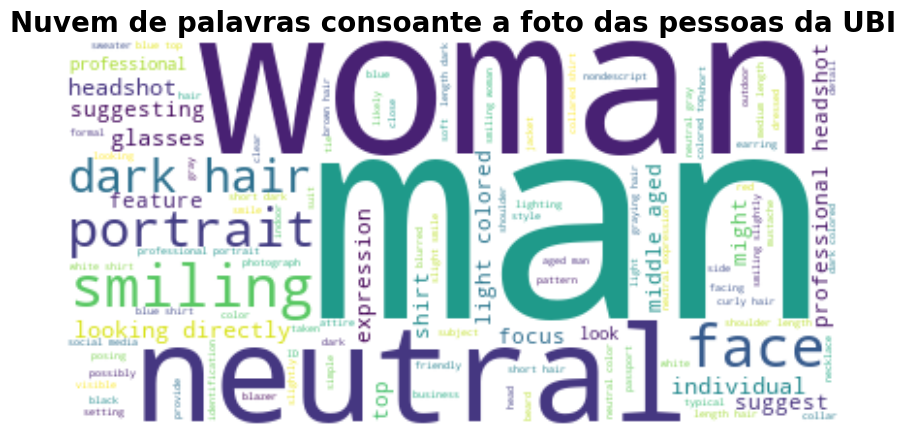

In [39]:
# Start with default stopwords from WordCloud, then add your own
stopwords = set(STOPWORDS)
# Add common prepositions (or any other words you want to exclude)
stopwords.update(['of', 'the', 'and', 'in', 'on', 'at', 'for', 'with', 'without', 
                  'about', 'Error processing photo','Photo not processed','used','seems','plain',
                  'image', 'shows', 'Error processing', 'processed', 'Photo', 'photo', 'wearing', 'seem',
                  'Error', 'processing', 'background','camera','appear','appears', 'person'])

# Combine all text from the 'photo_details' column into one string
# Make sure to drop NaN values to avoid conversion errors
text = ' '.join(detail for detail in df['photo_details'].dropna())

# Generate the word cloud
wordcloud = wordcloud = WordCloud(
                                    stopwords=stopwords,
                                    background_color='white',
                                    prefer_horizontal=0.7,
                                    min_font_size=5,  
                                    max_font_size=150,
                                    colormap='viridis'
                                ).generate(text)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de palavras consoante a foto das pessoas da UBI', fontsize=20, fontweight='bold')
plt.show()

# Tarefa 2

Familiarização com a obtenção de dados a partir de packages Python

1. Recorra ao package do wikipedia [https://pypi.org/project/wikipedia/] para criar um
dataset de 2000 imagens relacionadas com duas temáticas distintas à sua escolha
(e.g., covid e desporto)

In [32]:
!pip install wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11704 sha256=f668dd233276d2ff1c9ab9c980059230bd7d74b68add7480dbe9b75c93bf669e
  Stored in directory: c:\users\rene_\appdata\local\pip\cache\wheels\8f\ab\cb\45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [47]:
import wikipedia


In [48]:
wikipedia.set_lang("pt")

In [49]:
def wiki_page(page_name):
    try:
        wiki = wikipedia.page(page_name)
        data = {'title': wiki.title, 'content': wiki.content, 'summary': wiki.summary, 'url': wiki.url, 'categories': wiki.categories, 'wiki_links': wiki.links, 'image': wiki.images[0] if wiki.images else 'No image available'}
        return data
    except:
        return []

def wiki_scraping(page_name, num_links):
    data = []
    
    wiki_data = wiki_page(page_name)
    if len(wiki_data) == 0:  #se a pag principal não existir o processo termina
        return data
    
    data.append(wiki_data)
    
    wiki_links = wiki_data['wiki_links']
    min_num_links = min(len(wiki_links), num_links)

    for j in range(min_num_links):
        time.sleep(30)  
        wiki_data = wiki_page(wiki_links[j])
        if len(wiki_data) > 0:  #Apenas adiciona à lista se a pag wikipedia existir
            data.append(wiki_data)

        if j % 1 == 0:
            print(f"\r{100*j/min_num_links:.2f}%", end='')
    
    return data


In [57]:
lisbon = wiki_scraping("Lisboa", 20)

40.00%

c:\Users\rene_\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\rene_\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


95.00%

In [62]:
oporto = wiki_scraping("Porto Portugal", 20)

85.00%

c:\Users\rene_\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\rene_\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


95.00%

In [58]:
for item in lisbon[:5]:  # Loop through the first 5 dictionaries in the list
    print(item['image'])

https://upload.wikimedia.org/wikipedia/commons/f/fa/25_de_Abril_Bridge_%2836831608556%29.jpg
https://upload.wikimedia.org/wikipedia/commons/7/7a/Afonso_Costa.jpg
https://upload.wikimedia.org/wikipedia/commons/3/35/E-to-the-i-pi.svg
https://upload.wikimedia.org/wikipedia/commons/3/31/AnoFE.jpg
https://upload.wikimedia.org/wikipedia/commons/a/ae/502_0.svg


In [63]:
for item in oporto[:5]:  # Loop through the first 5 dictionaries in the list
    print(item['image'])

https://upload.wikimedia.org/wikipedia/commons/3/35/A5_HPIM4187_%281187023808%29.jpg
https://upload.wikimedia.org/wikipedia/commons/b/b5/AnoCB.jpg
https://upload.wikimedia.org/wikipedia/commons/d/d8/C-54landingattemplehof.jpg
https://upload.wikimedia.org/wikipedia/commons/a/ae/502_0.svg
https://upload.wikimedia.org/wikipedia/commons/a/ae/502_0.svg


In [65]:
lisbon = pd.DataFrame(lisbon)
oporto = pd.DataFrame(oporto)
lisbon['tematica'] = 'Lisboa'
oporto['tematica'] = 'Porto'
duas_tematicas = pd.concat([lisbon, oporto], ignore_index=True)

In [67]:
duas_tematicas.head(5)

title  \
0                               Lisboa   
1  13.º governo republicano (Portugal)   
2                        1 000 000 000   
3                                 2008   
4                    A12 (autoestrada)   

                                             content  \
0  Lisboa é a capital e maior cidade de Portugal,...   
1  O 13.º governo da Primeira República Portugues...   
2  1 000 000 000 (um bilhão, escala curta (portug...   
3  2008 (MMVIII, na numeração romana) foi um ano ...   
4  A A12 ou Autoestrada do Sul do Tejo é uma auto...   

                                             summary  \
0  Lisboa é a capital e maior cidade de Portugal,...   
1  O 13.º governo da Primeira República Portugues...   
2  1 000 000 000 (um bilhão, escala curta (portug...   
3  2008 (MMVIII, na numeração romana) foi um ano ...   
4  A A12 ou Autoestrada do Sul do Tejo é uma auto...   

                                                 url  \
0               https://pt.wikipedia.org/wiki/Lisboa   
1  https://pt.wikipedia.org/wiki/13.%C2%BA_govern...   
2        https://pt.wikipedia.org/wiki/1_000_000_000   
3                 https://pt.wikipedia.org/wiki/2008   
4    https://pt.wikipedia.org/wiki/A12_(autoestrada)   

                                          categories  \
0  [Categoria:!Artigos bons na Wikipédia em alemã...   
1  [Categoria:!CS1 manut: Usa parâmetro autores, ...   
2  [Categoria:!Artigos que carecem de notas de ro...   
3  [Categoria:!Artigos que carecem de notas de ro...   
4  [Categoria:!Páginas com mapas, Categoria:Autoe...   

                                          wiki_links  \
0  [13.º governo republicano (Portugal), 1 000 00...   
1  [1.º Governo da Carta, 1.º governo da Monarqui...   
2  [Algarismos indo-arábicos, Escalas curta e lon...   
3  [10 de junho, 10 de maio, 10 de novembro, 10 d...   
4  [A10 (autoestrada), A11 (autoestrada), A12-1 (...   

                                               image tematica  
0  https://upload.wikimedia.org/wikipedia/commons...   Lisboa  
1  https://upload.wikimedia.org/wikipedia/commons...   Lisboa  
2  https://upload.wikimedia.org/wikipedia/commons...   Lisboa  
3  https://upload.wikimedia.org/wikipedia/commons...   Lisboa  
4  https://upload.wikimedia.org/wikipedia/commons...   Lisboa

# Tarefa 3

1.  Recorra à API “Text Search” ou à API “Image Search” do Arquivo.pt para reunir um 
conjunto elevado de textos ou imagens que deverá guardar no seu computador.

In [81]:
import requests
import pandas as pd

def conjunto_imagens(tematica, quantidade_resultados=100):
    URL_REQUEST = "https://arquivo.pt/imagesearch"
    current_offset = 0

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/100.0"
    }

    # Initialize an empty DataFrame
    dataframe = pd.DataFrame()

    # Keep track of the total number of fetched items
    total_fetched = 0

    while total_fetched < quantidade_resultados:
        # Calculate how many items we need to fetch in this request
        items_to_fetch = min(100, quantidade_resultados - total_fetched)

        payload = {
            'q': tematica,
            'maxItems': items_to_fetch,
            'offset': current_offset
        }

        response = requests.get(URL_REQUEST, params=payload, headers=headers)
        if response.status_code == 200:
            contents = response.json()
            if 'responseItems' in contents and len(contents['responseItems']) > 0:
                # Convert the list of dictionaries to a DataFrame
                chunk_df = pd.DataFrame(contents['responseItems'])
                # Append the chunk DataFrame to the main DataFrame
                dataframe = pd.concat([dataframe, chunk_df], ignore_index=True)

                fetched_items = len(contents['responseItems'])
                total_fetched += fetched_items
                current_offset += fetched_items

                if fetched_items < items_to_fetch:
                    print("No more items to fetch.")
                    break  # Exit the loop if we fetched fewer items than requested, assuming we've reached the end
            else:
                print("No items in response.")
                break
        else:
            print(f"Failed to fetch items, status code: {response.status_code}")
            break  # Exit the loop on failure

    return dataframe


In [84]:
tematica = 'Universidade Beira Interior'
dataframe = conjunto_imagens(tematica=tematica, quantidade_resultados=30)


2.  Guarde os textos ou imagens na pasta /data/aaaa.mm.dd, onde aaaa.mm.dd é um valor 
que  deverá  ser  dinamicamente  obtido  a  partir  da  data  de  execução  do  código  (e.g., 
2020.05.26, no caso de o código ser executado no dia 26/05/2020). Proceda também à 
gravação  das  informações  correspondentes  (dos  textos  ou  das  imagens)  num  ficheiro 
JSON dentro da mesma pasta

In [85]:
print(dataframe.shape)
dataframe.head(5)

(30, 15)


imgDigest  \
0  2538ca2a4f84195bf75b339e416e91d4b17cf3c1e3778e...   
1  e9bfa877ce9b05d7e3dd9f986474e268baabb88808029a...   
2  10627ba0ffafd2661ef1398879200e979ea39b55141e42...   
3  e7060f92778e037b13eaaa0f569d3a30316f8473af40da...   
4  b8330c8d7de69de087b5837b54a56808b650d325f9f636...   

                                              imgSrc  \
0  https://culturas.cc/congresso2020/wp-content/u...   
1    http://www.ub.edu/escult/paudo/images/beira.jpg   
2  http://www.lousatextil.pt/images/emblema-unive...   
3  http://ufcovilhaecanhoso.pt/wp-content/uploads...   
4  https://culturas.cc/wp-content/uploads/2019/11...   

                                           pageTitle  imgHeight  imgWidth  \
0  congresso internacional sobre culturas – rede ...        150       150   
1     PAUDO. PUBLIC ART AND URBAN DESIGN OBSERVATORY         70       255   
2  Emblema Universidade Beira Interior - Lousãtextil        300       300   
3                  Estabelecimentos de Ensino – UFCC        480       640   
4  culturas.cc – rede internacional de pesquisado...        300       300   

  imgMimeType                                            pageURL  \
0   image/png                 https://culturas.cc/congresso2020/   
1  image/jpeg        http://www.ub.edu/escult/paudo/members.html   
2  image/jpeg  http://www.lousatextil.pt/produto/emblema-univ...   
3  image/jpeg  http://ufcovilhaecanhoso.pt/galerias/estabelec...   
4   image/png                               https://culturas.cc/   

        imgTstamp      pageTstamp  \
0  20201212080041  20201212075537   
1  20191121040340  20191121040208   
2  20120125135010  20120125134952   
3  20190322175006  20190322173405   
4  20210612042832  20210612042416   

                                          imgCaption  \
0  [Painéis | AO VIVO, VI Congresso Internacional...   
1  [Forma Urbis Lab CIAUD Universidad de Lisboa D...   
2  [Dimensões8,5 x 8,48 cm 2.21 € Custo Unitário ...   
3                       [Estabelecimentos de Ensino]   
4  [COOPERAÇÃO ACADÊMICA, CIENTÍFICA E CULTURAL O...   

                                              imgAlt  \
0  [Universidade Beira Interior, Universidade Bei...   
1                                              [UBI]   
2                                                NaN   
3                                                NaN   
4           [Universidade Beira Interior | Portugal]   

                                            imgTitle  \
0  [Universidade Beira Interior, Universidade Bei...   
1                      [Universidade Beira Interior]   
2              [Emblema Universidade Beira Interior]   
3                    [universidade beira interior 2]   
4           [Universidade Beira Interior | Portugal]   

                                   collection  \
0               [AWP36, AWP35, EAWP36, AWP39]   
1                                    [EAWP28]   
2  [AWP12, AWP16, AWP17, AWP21, AWP25, AWP26]   
3                             [EAWP39, AWP29]   
4                                     [AWP37]   

                                    imgLinkToArchive  \
0  https://arquivo.pt/wayback/20201212080041im_/h...   
1  https://arquivo.pt/wayback/20191121040340im_/h...   
2  https://arquivo.pt/wayback/20120125135010im_/h...   
3  https://arquivo.pt/wayback/20190322175006im_/h...   
4  https://arquivo.pt/wayback/20210612042832im_/h...   

                                   pageLinkToArchive  
0  https://arquivo.pt/wayback/20201212075537/http...  
1  https://arquivo.pt/wayback/20191121040208/http...  
2  https://arquivo.pt/wayback/20120125134952/http...  
3  https://arquivo.pt/wayback/20190322173405/http...  
4  https://arquivo.pt/wayback/20210612042416/http...

In [87]:
import pandas as pd
import requests
from datetime import datetime
import os
import time

def guardar_imagens(df, target_folder='tematica_imagens', retry_count=3, retry_delay=2):
    """
    Download images from URLs in the 'imgSrc' column of a DataFrame,
    and save them with a timestamp as the filename. Retries failed downloads up to `retry_count` times.

    :param df: DataFrame with a column 'imgSrc' containing image URLs.
    :param target_folder: Folder where images will be saved.
    :param retry_count: Number of times to retry downloading an image if the first attempt fails.
    :param retry_delay: Time in seconds to wait between retries.
    """
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/100.0"
    }

    for index, row in df.iterrows():
        image_url = row['imgSrc']
        attempts = 0
        while attempts < retry_count:
            try:
                response = requests.get(image_url, headers=headers, timeout=10)
                if response.status_code == 200:
                    timestamp = datetime.now().strftime('%Y%m%d%H%M%S%f')
                    file_extension = image_url.split('.')[-1].split('?')[0]  # Handle URLs with parameters
                    file_name = f"{timestamp}.{file_extension}"

                    with open(os.path.join(target_folder, file_name), 'wb') as f:
                        f.write(response.content)
                    print(f"Image saved as {file_name}")
                    break  # Exit the retry loop on success
                else:
                    print(f"Failed to download image from {image_url} with status code {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {image_url}: {e}")
            attempts += 1
            if attempts < retry_count:
                print(f"Retrying... Attempt {attempts + 1} of {retry_count}")
                time.sleep(retry_delay)  # Wait before retrying

    print("Download process completed.")


In [88]:
guardar_imagens(dataframe)

Image saved as 20240321230546833638.png
Image saved as 20240321230547173819.jpg
Failed to download image from http://www.lousatextil.pt/images/emblema-universidade-beira-interior-def.jpg with status code 404
Retrying... Attempt 2 of 3
Failed to download image from http://www.lousatextil.pt/images/emblema-universidade-beira-interior-def.jpg with status code 404
Retrying... Attempt 3 of 3
Failed to download image from http://www.lousatextil.pt/images/emblema-universidade-beira-interior-def.jpg with status code 404
Image saved as 20240321230555433267.jpg
Image saved as 20240321230556631706.png
Image saved as 20240321230557902565.png
Image saved as 20240321230558459297.jpg
Failed to download image from https://governacaointernet.pt/img/logo_ubi.png with status code 404
Retrying... Attempt 2 of 3
Failed to download image from https://governacaointernet.pt/img/logo_ubi.png with status code 404
Retrying... Attempt 3 of 3
Failed to download image from https://governacaointernet.pt/img/logo_ubi

In [93]:
file_name = "imagens.json"

# Convert the DataFrame to a list of dictionaries
data = dataframe.to_dict(orient='records')

# Convert the list of dictionaries to a JSON string with ensure_ascii=False
json_str = json.dumps(data, ensure_ascii=False, indent=4)

with open(file_name, "w", encoding='utf-8') as outfile:
    outfile.write(json_str)

3.  Carregue o ficheiro JSON em memória e percorra os conteúdos de 5 dos registos.  

In [94]:
arquivo_pt = "imagens.json"

with open(arquivo_pt, "r") as readfile:
    conjunto_json = json.load(readfile)

#Impressao com recurso ao pretty print - mais entendivel
if isinstance(conjunto_json, list) and len(conjunto_json) > 0:
    pprint.pprint(conjunto_json[:5])
else:
    print("JSON structure is not a list or is empty.")

[{'collection': ['AWP36', 'AWP35', 'EAWP36', 'AWP39'],
  'imgAlt': ['Universidade Beira Interior', 'Universidade Beira Interior'],
  'imgCaption': ['Painéis | AO VIVO',
                 'VI Congresso Internacional sobre Culturas – edição online A '
                 'Rede de Universidades dedicadas aos estudos das Culturas\n'
                 'políticos, econômicos, comunicacionais, tecnológicos e de '
                 'saúde que repercutem na cultura e por esta são agenciados.',
                 'A Rede de Universidades dedicadas aos estudos das Culturas '
                 'conforma uma importante iniciativa para o debate, a pesquisa '
                 'e a\n'
                 'políticos, econômicos, comunicacionais, tecnológicos e de '
                 'saúde que repercutem na cultura e por esta são agenciados.'],
  'imgDigest': '2538ca2a4f84195bf75b339e416e91d4b17cf3c1e3778ef1daa2d34e1bdec267',
  'imgHeight': 150,
  'imgLinkToArchive': 'https://arquivo.pt/wayback/20201212080041im_/ht

4. Reúna dois colegas e elabore uma proposta de candidatura ao Prémio Arquivo.pt 2024. 
Detalhe  e  explore,  junto  com  os  seus  colegas,  uma  descrição  sumária  da  ideia  tendo 
em  conta  o  seu  impacto  social  e  científico,  a  relevância  da  utilização  do  Arquivo.pt, 
originalidade e a exequibilidade da concretização do projeto. Para consultar os 
premiados das edições anteriores clique no seguinte link: 
https://sobre.arquivo.pt/pt/colabore/premios-arquivo-pt/